In [1]:
include("./prepare_data.jl")
include("./model.jl")

import .Model
import Flux

In [2]:
using CUDA 
device = Flux.gpu

flux_model = Model.model |> device

Chain(
  Recur(
    LSTMCell(128 => 64),                # 49_536 parameters
  ),
  MaxPool((2,)),
  Recur(
    LSTMCell(32 => 16),                 # 3_168 parameters
  ),
  Flux.flatten,
  Dense(48 => 3),                       # 147 parameters
  NNlib.softmax,
)         # Total: 12 trainable arrays, 52_851 parameters,
          # plus 4 non-trainable, 160 parameters, summarysize 1.789 KiB.

In [3]:
function flux_loss(model, x, y)
    ŷ = model(x)
    Flux.crossentropy(ŷ, y)
end

flux_loss (generic function with 1 method)

In [4]:
using ProgressMeter
using MLUtils 

data_loader = MLUtils.DataLoader(DataSet(ModelCfgs.D), batchsize=32) |> device
 opt_state  = Flux.setup(Flux.Adam(0.01),flux_model)


(layers = ((cell = (Wi = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), Wh = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), b = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), state0 = (Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8)

In [5]:
losses = []
epochs = 50
@showprogress for epoch in 1:epochs 
                    total_loss = 0.0
                    for (x,y) in data_loader
                        l = flux_loss(flux_model, x, y)
                        total_loss += l
                        Flux.train!(flux_loss, flux_model, [(x, y)], opt_state)
                    end
                    push!(losses,total_loss)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:25


In [6]:
losses

50-element Vector{Any}:
 28.263184033334255
 24.480039581656456
 24.54846501350403
 24.34689612686634
 24.764253690838814
 24.04436920583248
 23.823943227529526
 23.73806455731392
 23.595084384083748
 23.694481149315834
 23.47940966486931
 23.489858016371727
 23.373647436499596
  ⋮
 22.06861775368452
 20.979990735650063
 20.525486774742603
 20.418187603354454
 20.930185601115227
 20.56168734282255
 19.60193671286106
 19.513362646102905
 20.884623393416405
 21.012862488627434
 19.884836614131927
 19.465156614780426

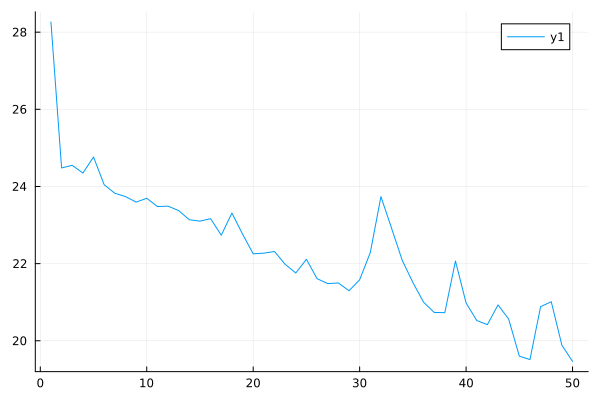

In [7]:
import Plots

Plots.plot(losses)

In [8]:
using Dates
now = Dates.now()
date_now = Dates.value(now)


63823370148126

In [9]:
io = open(string("./output/losses_",ModelCfgs.D,"_",date_now,".txt"),"w")
    for loss in losses 
        println(io,loss)
    end
close(io)

In [10]:
cpu_model = Flux.cpu(flux_model)

using BSON: @save
@save string("./output/mymodel_",ModelCfgs.D,"_",date_now,".bson") cpu_model

In [11]:
using Flux, BSON
BSON.@load string("./output/mymodel_",ModelCfgs.D,"_",date_now,".bson") cpu_model

In [12]:
Flux.params(cpu_model )

Params([Float32[-0.188282 -0.18201716 … 0.06686106 0.043630842; 0.3329563 0.14420821 … -0.59048605 -0.7231061; … ; 0.65614516 0.56824964 … 1.078157 1.0977316; -0.23495646 -0.35998252 … -0.6057262 -0.7743294], Float32[-0.46754938 -0.57128197 … -0.39288703 1.3213397; -0.57747793 0.381964 … -0.19382341 0.3154799; … ; -0.54098654 -0.24354644 … 0.21367739 -0.20267119; -0.42466635 -0.58793515 … -1.3413445 -0.5682041], Float32[-0.36987105, 0.51694065, -0.45055625, 0.33816114, -0.902048, -0.13197891, -0.39771762, -1.0302426, 0.106451645, 0.4461358  …  -0.12183185, -0.3654328, -0.16943304, 0.008364757, -0.30921453, -0.42549005, -0.6831345, -0.2842598, 0.2686309, 0.07717107], Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.26995748 0.52554905 … 0.60761154 0.114967905; 0.30933484 -0.05195652 … 0.31160134 0.33446726; … ; -0.36543247 -0.3780212 … -0.26465702 -0.3234747; -0.41236115 -0.26987013 … -0.46413624 -0.25125876], Float32[-0.44773397 0.33521786 … -0.14434317 0